# Topic Modeling of COVID-19 Open Research Dataset
## - Finding Business topics for publications on COVID-19
Since the COVID-19 pandemic, academic society has published many papers about COVID-19, SARS-CoV-2, and related coronaviruses. The Allen Institute for AI prepared the COVID-19 Open Research Dataset (CORD-19), a resource of over 200,000 scholarly articles, including over 100,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses.

The objective of this code is to use the latent Dirichlet allocation (LDA), a popular text mining method for topic modeling, to find business insight in the massive amount of publications on COVID-19.

I will explore the following questions.
* What do we know about business topics associate with COVID-19?
* What do we know about the topics that combine business and biology, or business and health care?
* What has been published about information sharing and management?
* What has been published about social science that may impact business?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import re
import nltk
from nltk.stem.porter import *
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import gensim
from gensim import corpora, models
import pickle

%matplotlib inline

C:\Users\zhipe\Anaconda3\envs\tm\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# 1. Read dataset.

Read metadata.csv downloaded from
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

In [2]:
meta = pd.read_csv("../metadata.csv")
print(meta.shape)
meta.head()

C:\Users\zhipe\Anaconda3\envs\tm\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(341713, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


Check the variable names of the dataset.

In [3]:
print(meta.columns)

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')


Filter meta file by selecting only papers after 2020.

In [4]:
meta["publish_time"] = pd.to_datetime(meta["publish_time"])
meta["publish_year"] = pd.DatetimeIndex(meta['publish_time']).year
meta["publish_month"] = pd.DatetimeIndex(meta['publish_time']).month
meta["publish_day"] = pd.DatetimeIndex(meta['publish_time']).day
meta = meta[meta["publish_year"] == 2020]
print(meta.shape[0], " papers are available after 2020 Jan 1.")

247255  papers are available after 2020 Jan 1.


Plot publication numbers in each month of 2020.

<AxesSubplot:xlabel='publish_year,publish_month'>

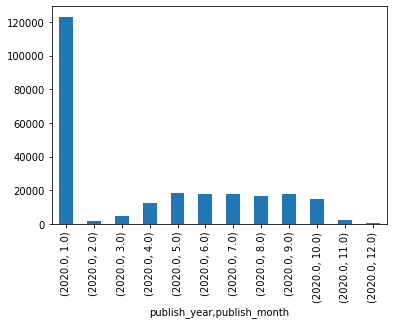

In [5]:
meta.groupby(["publish_year","publish_month"]).size().plot.bar()

* It is strange that most papers are published in the first month of 2020.
I plot the publication numbers in each day of 2020 Jan..

<AxesSubplot:xlabel='publish_day'>

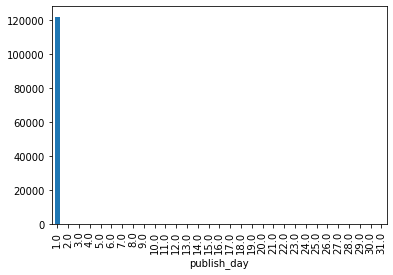

In [6]:
meta[(meta.publish_year==2020)&(meta.publish_month==1)].groupby(["publish_day"]).size().plot.bar()

* Most papers are published in Jan. 1st, 2020.
* I guess most papers in the dataset don't have exact publishing date and have benn marked 1/1/2020.

Create dataframe with all abstracts and use it as input corpus.
* Papers without abstract are dropped.

In [7]:
index = []
for i in range(len(meta)):
    if type(meta.iloc[i, 8]) != float:
        index.append(i)
docs = meta.iloc[index, 8]
print(docs.shape[0], "abstracts are collected.")

163820 abstracts are collected.


Document number is high. I sample 50,000 documents for reducing computing time.

In [8]:
samp_size = 50000 #Here, the size can be changed. 
samp_docs = docs.sample(n=samp_size,random_state=100)
samp_docs = samp_docs.reset_index(drop=True)
samp_docs.head()

0    BACKGROUND: Different skin manifestations of C...
1    SARS-CoV-2 is the cause of the worldwide outbr...
2    BACKGROUND: Multiple professional bodies have ...
3    Severe cases of COVID-19 are characterized by ...
4    The COVID-19 pandemic caused by the SARS-CoV-2...
Name: abstract, dtype: object

# 2. Preprocessing texts

Sentence level preprocess
* Lowercase + base filter
* Some basic normalization

In [9]:
def preprocess_sent(docs):
    """
    Get sentence level preprocessed data from raw texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    # Add missing delimiter: xxxThis is a --> xxx.
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', docs)  # before lower case
    # Make words all lower case.
    s = s.lower()
    # Remove < and >
    s = re.sub(r'&gt|&lt', ' ', s)
    # Remove letters that repeat more than 2 time.
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # Remove non-word characters that repeat more than 1 time.
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # Use string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # Remove words in parenthesis, which are assumed less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # [.?!]xxx --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    return s.strip()

text_lists = [preprocess_sent(text) for text in samp_docs]

 Word level preprocess

In [10]:
# define stemmer

p_stemmer = PorterStemmer()
# create stop words list
stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    |set(get_stop_words('pt'))
    |set(get_stop_words('pl'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    |set(get_stop_words('nl'))
    |set(["abstract","d","background", "methods", "results", "conclusion"])
))

In [11]:
def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed documents
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = [word for word in w_list if word.isalpha()]
    w_list = [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']
    w_list = [word for word in w_list if word not in stop_words]
    w_list = [p_stemmer.stem(word) for word in w_list]

    return w_list

token_lists = [preprocess_word(text) for text in text_lists]

Put abstract and token list together. In later on steps, the abstracts are used to demenstrate topics.
* Empty token lists are removed.

In [12]:
docs_token = [(samp_docs.iloc[i], token_lists[i]) for i in range(len(samp_docs)) if token_lists[i] != []]
samp_pd = pd.DataFrame.from_records(docs_token, columns=['Abstract','Token'])
token_lists = samp_pd.Token.to_list()
samp_pd.head()
# samp_pd.to_pickle("./samp_pd.pkl")

,Abstract,Token
0,BACKGROUND: Different skin manifestations of C...,"[manifest, lesion, hand, feet, chilblain, inci..."
1,SARS-CoV-2 is the cause of the worldwide outbr...,"[caus, outbreak, report, decemb, case, death, ..."
2,BACKGROUND: Multiple professional bodies have ...,"[bodi, recommend, diabet, criteria, fast, gluc..."
3,Severe cases of COVID-19 are characterized by ...,"[case, inflammatori, process, failur, death, i..."
4,The COVID-19 pandemic caused by the SARS-CoV-2...,"[pandem, viru, ten, thousand, death, spain, he..."


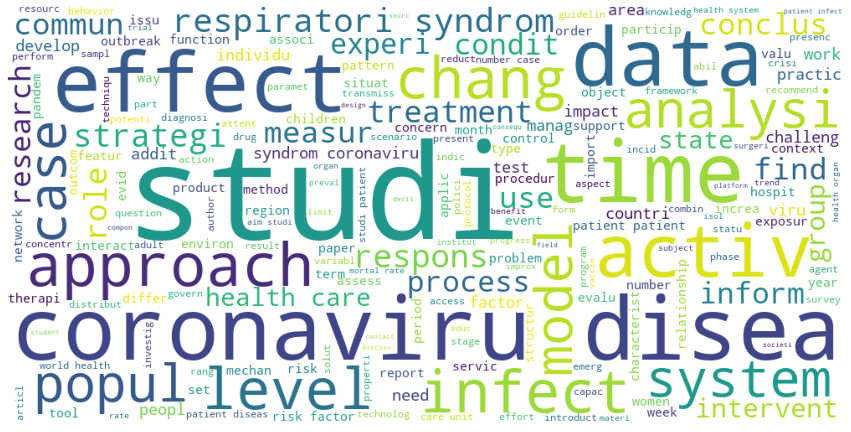

In [13]:
unique_string=" ".join([ " ".join(tl) for tl in token_lists])
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("word_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

# 4. Define model object

In [14]:

# create dictionary from token lists.
dictionary = corpora.Dictionary(token_lists)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in token_lists]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [16]:
def create_lda(corp, dict, ntopic, saved_file_name):
    """
    A function to create LDA model.
    :param corp: document-term matrix created from token_lists.
    :param dict: dictionary created from token lists.
    :param ntopic: number of topics.
    :param saved_file_name: the file name for saving the LDA model.
    :return
    """
    model = gensim.models.ldamodel.LdaModel(corp,
                                           num_topics=ntopic,
                                           random_state=66,
                                           id2word=dict , passes=20)
    model.save(saved_file_name)
    return model

lda_model = create_lda(corp=corpus, dict=dictionary, ntopic=100, saved_file_name="LDA_model.gensim")

In [17]:
# Load data and model.

# samp_pd = pd.read_pickle("samp_pd.pkl")
# dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
# corpus = pickle.load(open('corpus.pkl', 'rb'))
# lda_model = gensim.models.ldamodel.LdaModel.load("LDA_model.gensim")

# 5. Post-analysis
Print topics as keywords.

In [18]:
for topic in lda_model.print_topics(num_topics=100):
    print(topic)

(0, '0.088*"anxieti" + 0.071*"stress" + 0.055*"depress" + 0.053*"life" + 0.041*"symptom" + 0.041*"studi" + 0.039*"health" + 0.035*"qualiti" + 0.027*"scale" + 0.027*"distress"')
(1, '0.128*"theori" + 0.083*"code" + 0.063*"intent" + 0.050*"nutrit" + 0.049*"prone" + 0.040*"substitut" + 0.033*"subtyp" + 0.033*"repeat" + 0.033*"reveal" + 0.032*"frame"')
(2, '0.178*"risk" + 0.110*"factor" + 0.080*"mortal" + 0.052*"diseas" + 0.028*"diabet" + 0.025*"outcom" + 0.025*"regress" + 0.024*"age" + 0.023*"comorbid" + 0.021*"studi"')
(3, '0.186*"rate" + 0.074*"year" + 0.073*"popul" + 0.067*"age" + 0.062*"incid" + 0.059*"preval" + 0.040*"studi" + 0.035*"proport" + 0.028*"data" + 0.020*"differ"')
(4, '0.059*"polici" + 0.043*"crisi" + 0.041*"govern" + 0.040*"food" + 0.034*"pandem" + 0.027*"countri" + 0.024*"impact" + 0.024*"respons" + 0.022*"resourc" + 0.019*"capac"')
(5, '0.124*"energi" + 0.113*"space" + 0.066*"transfer" + 0.064*"complex" + 0.063*"task" + 0.063*"forc" + 0.061*"movement" + 0.048*"build" +

The Dominant topic and its percentage contribution in each document

In [19]:
def dominant_topic(ldamodel, corp, texts, saved_file_name):
    """
    Determine the dominant topic and its percentage contribution in each documents.
    :param ldamodel: LDA model.
    :param corp: corpus.
    :param texts: Documents.
    :param saved_file_name: The file name for saving the dataframe.
    :return: A dataframe having the dominant topic, topic percentage contribution, keywords, and Abstract.
    """
    topic_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corp]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if row:
            topic_num,prop_topic = row[0]
            topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(topic_num)])
            topic_df = topic_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
           topic_df = topic_df.append(pd.Series([10000, round(0.0,4), ""]), ignore_index=True)
    topic_df = pd.concat([topic_df, texts], axis=1)
    topic_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Abstract']
    topic_df.to_pickle(saved_file_name)
    return topic_df

text_topic_df = dominant_topic(ldamodel=lda_model, corp=corpus, texts=samp_pd.Abstract,saved_file_name="text_topics.pkl")
text_topic_df.head(3)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract
0,72.0,0.1849,"case, symptom, patient, present, fever, manife...",BACKGROUND: Different skin manifestations of C...
1,20.0,0.1750,"case, number, countri, death, data, rate, grow...",SARS-CoV-2 is the cause of the worldwide outbr...
2,7.0,0.3146,"control, concentr, studi, extract, effect, sta...",BACKGROUND: Multiple professional bodies have ...


Find the most representative abstract for each topic

In [2]:
# comment this code block in the first run. 
# Load previously created data and model.

samp_pd = pd.read_pickle("samp_pd.pkl")
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_model = gensim.models.ldamodel.LdaModel.load("LDA_model.gensim")
text_topic_df = pickle.load(open("text_topics.pkl", 'rb'))


In [68]:
def show_topic(text_topic, topic_num, first_n_abstract):
    """
    Show a topic using representative abstracts.
    :param text_topic: a dateframe with topic percentage contribution of each abstract.
    :param topic_num: the topic number.
    :param first_n_abstract: the number of the abstract to be shown.  
    """
    topic_group = text_topic_df[text_topic_df["Dominant_Topic"] == topic_num]
    topic_group = topic_group.sort_values(['Topic_Perc_Contrib'], ascending=False)
#     print("Topic ", topic_num)
    cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1500,
                  colormap='tab10',
                  prefer_horizontal=1.0
                  )
    cloud.generate_from_frequencies(dict(lda_model.show_topic(topic_num, topn=30)), max_font_size=300)
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(cloud, interpolation='bilinear')
    plt.title('Topic ' + str(topic_num+1), fontdict=dict(size=16))
    plt.axis("off")
    plt.show()
    print("Keywords", topic_group["Keywords"].iloc[0])
    for i in range(first_n_abstract):
        print(topic_group["Abstract"].iloc[i])
        print(topic_group['Topic_Perc_Contrib'].iloc[i])

# 6. Topics with Business Insights 

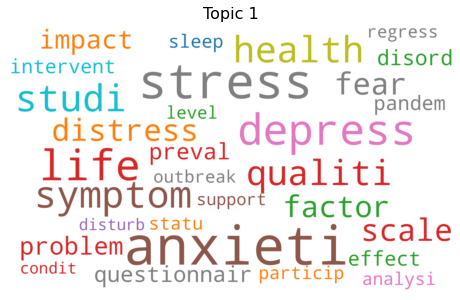

Keywords anxieti, stress, depress, life, symptom, studi, health, qualiti, scale, distress
BACKGROUND: It is well known that unexpected pandemic has led to an increase in mental health problems among a variety of populations. METHODS: In this study, an online non-probability sample survey was used to anonymously investigate the anxiety and depression symptoms among medical staff under the COVID-19 outbreak. The questionnaire included Perceived Stress Scale-10 (PSS-10), Generalized Anxiety Disorder 7-Item Scale (GAD-7) and Patient Health Questionnaire-9 (PHQ-9). Factors associated with anxiety and depression symptoms were estimated by logistic regression analysis. RESULTS: A total of 1090 medical staff were investigated in this study. The estimated self-reported rates of anxiety symptoms, depression symptoms and both of the two were 13.3%, 18.4% and 23.9% respectively. Factors associated with self-reported anxiety symptoms include married status (OR=2.3, 95%CI: 1.2, 4.4), not living alon

In [69]:
show_topic(text_topic_df, 0,1)

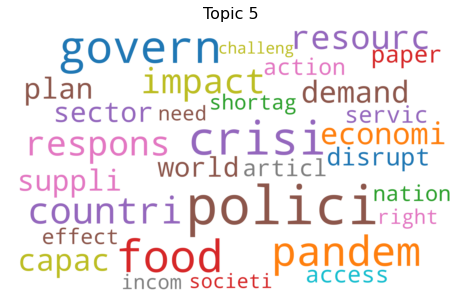

Keywords polici, crisi, govern, food, pandem, countri, impact, respons, resourc, capac
The multiple faces of the Coronavirus Disease 2019 (COVID-19), also included the impact on the economy. As a consequence of the significant life and society disruption, multiple implications are derived from the COVID-19 crisis and pandemic, including a significant backward on the economy. In the current mini-review, we discuss some potential considerations about it, including some specific examples of the COVID-19 impact on the economy.
0.6585000157356262
During the Covid-19 global pandemic, and in the face of an imminent crisis derived from it, various concerns arise regarding the economic consequences that the situation will bring, as well as whether the response of the different governments will be enough in the long term. The Foundational Economy Collective proposes, for the European context in particular, a series of points and lessons for the economic policy decisions that emerge from this cri

In [83]:
show_topic(text_topic_df, 4,6)

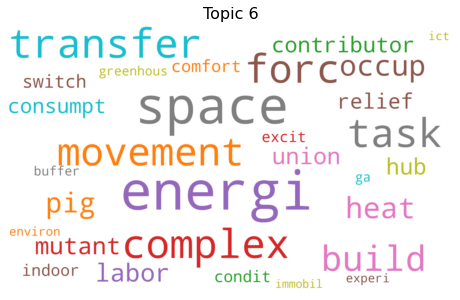

Keywords energi, space, transfer, complex, task, forc, movement, build, heat, occup
The major light-harvesting complex of photosystem II (LHCII) is the main contributor to sunlight energy harvesting in plants. The flexible design of LHCII underlies a photoprotective mechanism whereby this complex switches to a dissipative state in response to high light stress, allowing the rapid dissipation of excess excitation energy (non-photochemical quenching, NPQ). In this work, we locked single LHCII trimers in a quenched conformation after immobilization of the complexes in polyacrylamide gels to impede protein interactions. A comparison of their pigment excited-state dynamics with quenched LHCII aggregates in buffer revealed the presence of a new spectral band at 515 nm arising after chlorophyll excitation. This is suggested to be the signature of a carotenoid excited state, linked to the quenching of chlorophyll singlet excited states. Our data highlight the marked sensitivity of pigment exci

In [85]:
show_topic(text_topic_df, 5,6)

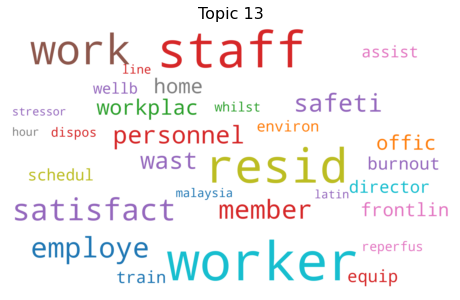

Keywords worker, staff, resid, work, satisfact, employe, member, safeti, personnel, wast
The COVID-19 pandemic has underscored the essential role of public safety personnel in serving and protecting all Canadians. Public safety personnel were reporting challenges with mental health and well-being before the COVID-19 pandemic; accordingly, the new stressors may mean public safety personnel need additional resources to sustainably help them help us. This article suggests elements of support that may be attainable avenues for supporting the well-being of public safety personnel during the protracted stress caused by the COVID-19 pandemic. Sustained self-care may be critical for maintaining the mental health and well-being of public safety personnel during the COVID-19 pandemic.
0.460099995136261
The coronavirus disease 2019 (COVID-19) pandemic has posed significant changes to resident education and workflow. However, the impact of the pandemic on U.S. neurosurgery residents has not been w

In [86]:
show_topic(text_topic_df, 12,3)

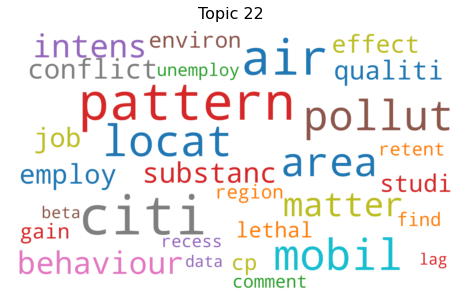

Keywords citi, pattern, air, locat, mobil, pollut, area, matter, intens, behaviour
We construct a new measure of the aggressiveness of COVID-19 policies in 75 Canadian and American cities and estimate the effect of these policies on mobility patterns in each city Using a new dataset of five municipal COVID-19 policy indicators for each of our 75 cities, combined with 11 provincial/state policy indicators, we estimate a daily measure of the “aggressiveness” of the provincial/state and municipal COVID-19 policy mix in each city We then estimate the effects of these policies on subsequent mobility behaviour using dynamic time series models We find strong evidence of policy effects on subsequent mobility behaviour, but few overall differences between Canadian and American cities We discuss the significance of our findings both for COVID-19 policy research and for other comparative urban policy research in multilevel policy environments © Canadian Public Policy / Analyse de politiques, Augu

In [87]:
show_topic(text_topic_df, 21,3)

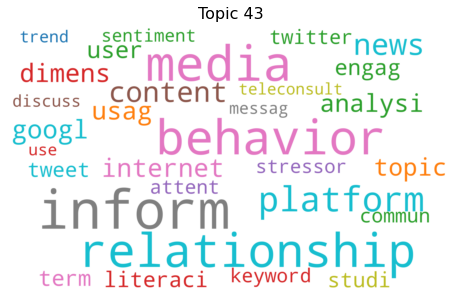

Keywords inform, media, behavior, relationship, platform, news, content, googl, internet, dimens
Pre-print servers have helped to rapidly publish important information during the COVID-19 pandemic. The downside is the risk of spreading false information or fake news though.
0.6019999980926514
Pre-print servers have helped to rapidly publish important information during the COVID-19 pandemic. The downside is the risk of spreading false information or fake news though.
0.6019999980926514
The COVID-19 pandemic has produced a flurry of online activity on social media sites. As such, analysis of social media data during the COVID-19 pandemic can produce unique insights into discussion topics and how those topics evolve over the course of the pandemic. In this study, we propose analyzing discussion topics on Twitter by clustering hashtags. In order to obtain high-quality clusters of the Twitter hashtags, we also propose a novel multi-view clustering technique that incorporates multiple diffe

In [88]:
show_topic(text_topic_df,42,6)

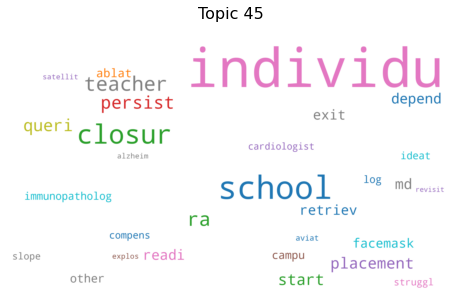

Keywords individu, school, closur, teacher, ra, persist, queri, start, placement, md
We aimed to investigate the confirmed COVID-19 cases among students and teachers in elementary schools (ages 6-12 years) and junior high schools (ages 13-15 years) in Japan between 1 June and 31 July 2020 We requested all schools to provide reports when students or teachers tested positive for COVID-19 A total of 207 cases were reported among students Household transmission was identified as the dominant transmission route, confirmed in 71 4% of elementary schools and 60 3% of junior high schools A total of 39 cases were reported among teachers, of which transmission route was unknown in 72 4% of elementary schools and 90 0% of junior high schools
0.33550000190734863
Social distancing mandated by COVID-19 so as to slow viral spread has resulted in school closures. It is now the end of summer 2020 and schools are starting. Reopening schools could be safe if accompanied by precautionary measures. This pa

In [89]:
show_topic(text_topic_df,44,3)

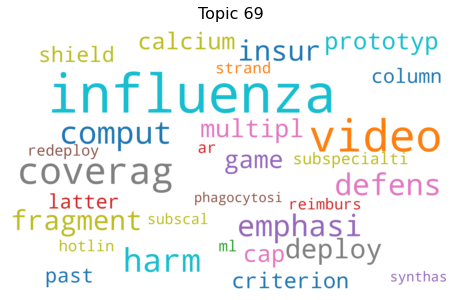

Keywords influenza, video, coverag, harm, comput, emphasi, defens, insur, fragment, deploy
Watch a video of this article
0.3366999924182892
BACKGROUND: The current 2019 novel coronavirus outbreak is rapidly evolving. YouTube has been recognized as a popular source of information in previous disease outbreaks. We analyzed the content on YouTube about n-CoV in English and Mandarin languages. METHODS: YouTube was searched using the terms '2019 novel coronavirus', 'Wuhan virus' and '' (Mandarin for Wuhan virus) on 1st and 2nd February 2020. First 50 videos in each group were analyzed. Videos in other languages, duplicate videos, those without an audio and duration >15 min were excluded .72 videos in English and 42 in Mandarin were reviewed. 2 reviewers classified the videos as useful, misleading or news based on pre specified criterion. Inter-observer agreement was evaluated with kappa coefficient. Modified DISCERN index for reliability and medical information and content index (MICI) scor

In [90]:
show_topic(text_topic_df,68,6)

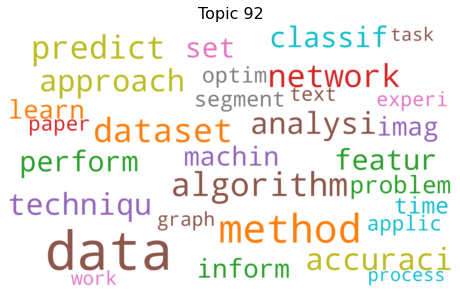

Keywords data, method, dataset, algorithm, predict, network, accuraci, approach, analysi, techniqu
A large amount of labelled data (absolute information) is usually needed for an ordinal classifier to attain a good performance. As shown in a recent paper by the present authors, the lack of a large amount of absolute information can be overcome by additionally considering some side information in the form of relative information, thus augmenting the method of nearest neighbors. In this paper, we adapt the method of nearest neighbors for dealing with a specific type of relative information: frequency distributions of pairwise comparisons (rather than a single pairwise comparison). We test the proposed method on some classical machine learning datasets and demonstrate its effectiveness.
0.7531999945640564
Medical image segmentation is a fundamental and challenging problem for analyzing medical images due to the approximate pixel values of adjacent tissues in boundary and the non-linear fe

In [91]:
show_topic(text_topic_df,91,3)

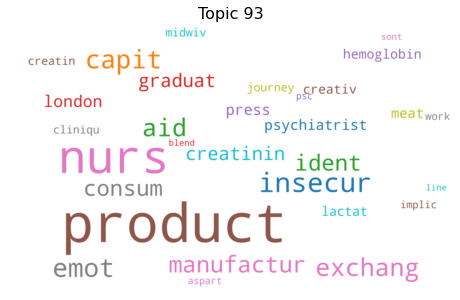

Keywords product, nurs, insecur, emot, capit, aid, exchang, manufactur, ident, consum
La production in vitro de plaquettes offre une opportunité de résoudre les problèmes liés aux limitations d’approvisionnement et à la sécurité des dons de produits dérivés du sang. Les cellules souches pluripotentes induites – ou iPSC – sont une source idéale pour la production de cellules à des fins de thérapies régénératives. Nous avons précédemment établi avec succès une lignée mégacaryocytaire immortalisée à partir d’iPSC. Celle-ci possède une capacité de prolifération fiable. Par ailleurs, il est possible de les cryoconserver. Elle est donc une source adaptée de cellules primaires pour la production de plaquettes suivant les Bonnes Pratiques de Fabrication (BPF). Dans le même temps, la capacité améliorée des bioréacteurs à reproduire certaines conditions physiologiques, telle que la turbulence, de pair avec la découverte de molécules favorisant la thrombopoïèse, a contribué à l’accomplissement de

In [78]:
show_topic(text_topic_df,92,6)

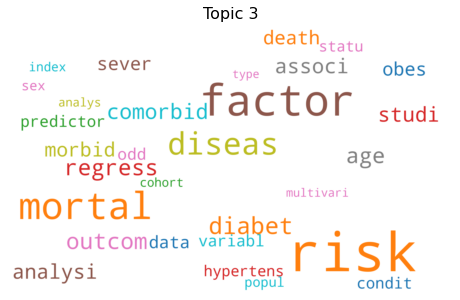

Keywords risk, factor, mortal, diseas, diabet, outcom, regress, age, comorbid, studi
Background: Identifying risk factors disease characteristics, severity and mortality of COVID-19 are poorly clear, particularly in Egypt brbrObjectives:
0.8586000204086304
Diabetes mellitus vormt een aanzienlijke ziektelast in Nederland; ruim 1,2 miljoen Nederlanders hebben diabetes, waarvan 90 procent type 2-diabetes. De daarmee gepaard gaande economische last wordt geschat op ruim 6,9 miljard euro. De prevalentie zal naar verwachting in de toekomst nog verder toenemen als gevolg van toenemende obesitas en een vergrijzende bevolking. Er is dus een dringende behoefte om goede diabeteszorg in Nederland toekomstbestendiger en patiëntgerichter te maken. Het meten en vergelijken van gezondheidsuitkomsten - en het identificeren van de oorzaken van variatie - helpt om gebieden te identificeren waar betere resultaten en efficiëntieverbeteringen kunnen worden bereikt. Op dit moment zijn de cijfers over diabete

In [81]:
show_topic(text_topic_df,2,3)

Use pyLDAvis tool to perform visualization.

In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=dictionary,R=10,sort_topics=False)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.163518  0.142614       1        1  1.400683
1      0.121847 -0.016939       2        1  0.309612
2     -0.170370  0.152047       3        1  2.557728
3     -0.123995  0.235342       4        1  1.701327
4     -0.173188 -0.205796       5        1  2.223385
...         ...       ...     ...      ...       ...
95    -0.086026  0.141565      96        1  1.212866
96    -0.240642  0.141550      97        1  5.156633
97     0.130567 -0.014099      98        1  0.277222
98     0.090671 -0.012237      99        1  0.629145
99     0.113203 -0.016651     100        1  0.410587

[100 rows x 5 columns], topic_info=           Term          Freq         Total  Category  logprob  loglift
28      patient  74591.000000  74591.000000   Default  10.0000  10.0000
102      infect  27666.000000  27666.000000   Default   9.0000   9.0000
167      health  29163.000000  29163.000000   Default   8.0000   8.0000
287       model  16833.000000  16833.000000   Default   7.0000   7.0000
296   treatment  17840.000000  17840.000000   Default   6.0000   6.0000
...         ...           ...           ...       ...      ...      ...
8499     insect     98.665470     99.718718  Topic100  -4.7718   5.4847
101      failur   2270.948324   3050.881006  Topic100  -1.6356   5.2001
1122   fraction    510.971510    623.541197  Topic100  -3.1272   5.2962
1027      phone    340.845766    464.990758  Topic100  -3.5321   5.1848
1002       york    256.403733    705.608410  Topic100  -3.8168   4.4830

[1717 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6166     98  0.997601        ab
6396     57  0.992972  abstract
1339     16  0.998117     abund
1956     77  0.996899      abus
4098     49  0.992720        ac
...     ...       ...       ...
5247     25  0.997487      zinc
6792      3  0.989308        zn
2484     17  0.996625      zone
4786     75  0.991024        µm
3393     38  0.997070       été

[3777 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])